In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, silhouette_samples, silhouette_score
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
import sklearn
import statsmodels
import statsmodels.formula.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import requests
import pprint
import xgboost
import scipy
import warnings
from datetime import datetime
from scipy import stats
from xgboost import XGBClassifier
from urllib import parse
from bs4 import BeautifulSoup

# 지수 형태의 실수를 소수점 3자리까지 표기
pd.options.display.float_format = "{:.3f}".format

# 공유 폴더 경로(나중에 경로 변경)
dirShare = ".."

warnings.filterwarnings("ignore")


In [2]:
# 라이브러리 버전 확인
print("pandas 현재 버전 : " + pd.__version__)
print("scikit-learn 현재 버전 : " + sklearn.__version__)
print("scipy 현재 버전 : "+ scipy.__version__)
print("statsmodels 현재 버전 : " + statsmodels.__version__)
print("xgboost 현재 버전 : " + xgboost.__version__)

pandas 현재 버전 : 2.0.3
scikit-learn 현재 버전 : 1.3.0
scipy 현재 버전 : 1.11.1
statsmodels 현재 버전 : 0.14.0
xgboost 현재 버전 : 1.7.6


# 데이터 불러오고 전처리

## 기본전처리

In [130]:
# def pre_data(datadir=None) : 
#     df = pd.read_csv(datadir)
#     df["ownerChange"].replace({"same":0},inplace=True)
#     df["ownerChange"].replace({"change":1},inplace=True)
#     df = pd.get_dummies(df, columns=["instkind"], prefix=["instkind"], prefix_sep="_", dtype=int)
#     df.dropna(axis=0, how="any", inplace=True)


In [3]:
# train.csv 데이터 프레임으로 불러오기
df = pd.read_csv(dirShare+"/data/train.csv")

# df 정보 확인
df.info()

# df 상위 10개 불러오기
# df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 58 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   inst_id             301 non-null    int64  
 1   OC                  301 non-null    object 
 2   sido                301 non-null    object 
 3   sgg                 301 non-null    int64  
 4   openDate            301 non-null    int64  
 5   bedCount            296 non-null    float64
 6   instkind            300 non-null    object 
 7   revenue1            293 non-null    float64
 8   salescost1          293 non-null    float64
 9   sga1                293 non-null    float64
 10  salary1             293 non-null    float64
 11  noi1                293 non-null    float64
 12  noe1                293 non-null    float64
 13  interest1           293 non-null    float64
 14  ctax1               293 non-null    float64
 15  profit1             293 non-null    float64
 16  liquidAs

In [132]:
# X_t = pd.read_csv(dirShare+"/data/test.csv")

# X_t.info()
# X_t.head()

In [133]:
# X_t.shape[0] - X_t.count()

In [5]:
# 데이터 개수 확인하기
print("데이터 개수 : ", df.shape[0])

# len(df)를 써도 동일

데이터 개수 :  301


In [135]:
# 숫자 형식의 컬럼의 기술통계값을 출력
# df.describe()

In [11]:
# 컬럼별 null 값 확인하기
df_null_count = (df.shape[0] - df.count()).to_frame()

df_null_count

,0
inst_id,0
OC,0
sido,0
sgg,0
openDate,0
bedCount,5
instkind,1
revenue1,8
salescost1,8
sga1,8


In [15]:
df

,inst_id,OC,sido,sgg,openDate,bedCount,instkind,revenue1,salescost1,sga1,...,debt2,liquidLiabilities2,shortLoan2,NCLiabilities2,longLoan2,netAsset2,surplus2,employee1,employee2,ownerChange
0,1,open,choongnam,73,20071228,175.000,nursing_hospital,4217530010.000,0.000,3961134739.000,...,758993742.000,222876855.000,0.000,536116887.000,390000000.000,2619290493.000,1271224493.000,62.000,64.000,same
1,3,open,gyeongnam,32,19970401,410.000,general_hospital,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,801.000,813.000,same
2,4,open,gyeonggi,89,20161228,468.000,nursing_hospital,1004521989.000,515483669.000,447219722.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,234.000,1.000,same
3,7,open,incheon,141,20000814,353.000,general_hospital,72507342181.000,0.000,70677397660.000,...,37755010512.000,17018596586.000,9219427379.000,20736413926.000,15100000000.000,12954271998.000,7740829037.000,663.000,663.000,same
4,9,open,gyeongnam,32,20050901,196.000,general_hospital,49043538016.000,0.000,47656051197.000,...,51432592890.000,30072585842.000,17593752360.000,21360007048.000,14108027465.000,5561941.000,9025549604.000,206.000,197.000,same
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296,422,open,jeonnam,178,20050211,214.000,nursing_hospital,7614696536.000,415347464.000,5903119133.000,...,9423771130.000,2618201328.000,0.000,6805569802.000,5930000000.000,5379501732.000,811641602.000,193.000,141.000,same
297,423,close,choongnam,159,20140618,NaN,hospital,6717143911.000,8200000000.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,79.000,79.000,same
298,426,close,gyeongbuk,107,19830705,NaN,hospital,0.000,0.000,54794278.000,...,6370097200.000,2170972735.000,0.000,4199124465.000,2498749346.000,3259161079.000,0.000,NaN,NaN,NaN
299,427,close,gyeonggi,169,20070101,180.000,nursing_hospital,2116892231.000,268174808.000,3286244912.000,...,639233573.000,6400000000.000,0.000,0.000,0.000,0.000,0.000,100.000,NaN,NaN


In [16]:
# 아직 운영 중인 병원을 1로 변환
df.replace({"open":1},inplace=True)
# 폐업한 병원을 0으로 변환
df.replace({" close":0}, inplace=True)
# unique() 메서드를 통해 "OC" 컬럼의 데이터를 확인
# df["OC"].unique()

In [17]:
df[['ownerChange']]

,ownerChange
0,same
1,same
2,same
3,same
4,same
...,...
296,same
297,same
298,NaN
299,NaN


In [18]:
# 오너 변환 여부
df["ownerChange"].replace({"same":0},inplace=True)
df["ownerChange"].replace({"change":1},inplace=True)
# df["ownerChange"].unique()

In [19]:
df["instkind"].unique()

array(['nursing_hospital', 'general_hospital', 'hospital',
       'traditional_clinic', 'clinic', 'traditional_hospital',
       'dental_clinic', nan], dtype=object)

In [140]:
df_clst = df[["inst_id","OC", "bedCount", "profit1", "surplus1", "profit2", "surplus2", 
                  "employee1", "employee2", "instkind", "sido"]]

df_clst.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   inst_id    301 non-null    int64  
 1   OC         301 non-null    int64  
 2   bedCount   296 non-null    float64
 3   profit1    293 non-null    float64
 4   surplus1   293 non-null    float64
 5   profit2    293 non-null    float64
 6   surplus2   293 non-null    float64
 7   employee1  291 non-null    float64
 8   employee2  288 non-null    float64
 9   instkind   300 non-null    object 
 10  sido       301 non-null    object 
dtypes: float64(7), int64(2), object(2)
memory usage: 26.0+ KB


In [141]:
# 병원의 종류를, get_dummies를 이용해 one-hot-encoding
df = pd.get_dummies(df, columns=["instkind"], prefix=["instkind"], prefix_sep="_", dtype=int)
df_clst = pd.get_dummies(df_clst, columns=["instkind"], prefix=["instkind"], prefix_sep="_", dtype=int)

In [142]:
# 개업한 날짜는 변수로서 의미가 없음. 모델은 날짜를 인식하지 못하기 때문에
# 개업 날짜와 폐업 날짜의 차이로 변수를 조정할 필요가 있음

date_of_2018 = "2018-01-01"

# 문자 타입을 date 타입으로

df["openDate"] = df["openDate"].apply(lambda x : datetime.strptime(str(x), "%Y%m%d"))

# 날짜 차이를 새로운 컬럼으로 생성, 데이터 프레임 중간에 삽입
df.insert(1, "dif_date", datetime.strptime(date_of_2018,"%Y-%m-%d")-df["openDate"])
df["dif_date"] = df["dif_date"].dt.days

df["dif_date"].tail()

296     4707
297     1293
298    12599
299     4018
300     5920
Name: dif_date, dtype: int64

In [143]:
df_clst.insert(1, column="dif_date", value=df["dif_date"])
df_clst.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 18 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   inst_id                        301 non-null    int64  
 1   dif_date                       301 non-null    int64  
 2   OC                             301 non-null    int64  
 3   bedCount                       296 non-null    float64
 4   profit1                        293 non-null    float64
 5   surplus1                       293 non-null    float64
 6   profit2                        293 non-null    float64
 7   surplus2                       293 non-null    float64
 8   employee1                      291 non-null    float64
 9   employee2                      288 non-null    float64
 10  sido                           301 non-null    object 
 11  instkind_clinic                301 non-null    int32  
 12  instkind_dental_clinic         301 non-null    int

In [144]:
# 영어로 돼 있는 '시도'를 한글로 변환

df["sido"].replace(['choongnam', 'gyeongnam', 'gyeonggi', 'incheon', 'busan',
       'jeonnam', 'seoul', 'jeonbuk', 'choongbuk', 'ulsan', 'daejeon',
       'daegu', 'gyeongbuk', 'gangwon', 'gwangju', 'sejong'], 
       ["충청남도", "경상남도", "경기도", "인천광역시", '부산광역시', '전라남도', '서울특별시', 
        '전라북도', '충청북도', '울산광역시', '대전광역시', '대구광역시', "경상북도", "강원도", "광주광역시", "세종특별자치시"],inplace=True)

df_clst["sido"].replace(['choongnam', 'gyeongnam', 'gyeonggi', 'incheon', 'busan',
       'jeonnam', 'seoul', 'jeonbuk', 'choongbuk', 'ulsan', 'daejeon',
       'daegu', 'gyeongbuk', 'gangwon', 'gwangju', 'sejong'], 
       ["충청남도", "경상남도", "경기도", "인천광역시", '부산광역시', '전라남도', '서울특별시', 
        '전라북도', '충청북도', '울산광역시', '대전광역시', '대구광역시', "경상북도", "강원도", "광주광역시", "세종특별자치시"],inplace=True)

print("df의 시도 : ",df["sido"].unique())
print("df_clst의 시도 : ",df_clst["sido"].unique())

df의 시도 :  ['충청남도' '경상남도' '경기도' '인천광역시' '부산광역시' '전라남도' '서울특별시' '전라북도' '충청북도' '울산광역시'
 '대전광역시' '대구광역시' '경상북도' '강원도' '광주광역시' '세종특별자치시']
df_clst의 시도 :  ['충청남도' '경상남도' '경기도' '인천광역시' '부산광역시' '전라남도' '서울특별시' '전라북도' '충청북도' '울산광역시'
 '대전광역시' '대구광역시' '경상북도' '강원도' '광주광역시' '세종특별자치시']


### 데이터 시각화 

In [23]:
df.columns

Index(['inst_id', 'OC', 'sido', 'sgg', 'openDate', 'bedCount', 'instkind',
       'revenue1', 'salescost1', 'sga1', 'salary1', 'noi1', 'noe1',
       'interest1', 'ctax1', 'profit1', 'liquidAsset1', 'quickAsset1',
       'receivableS1', 'inventoryAsset1', 'nonCAsset1', 'tanAsset1',
       'OnonCAsset1', 'receivableL1', 'debt1', 'liquidLiabilities1',
       'shortLoan1', 'NCLiabilities1', 'longLoan1', 'netAsset1', 'surplus1',
       'revenue2', 'salescost2', 'sga2', 'salary2', 'noi2', 'noe2',
       'interest2', 'ctax2', 'profit2', 'liquidAsset2', 'quickAsset2',
       'receivableS2', 'inventoryAsset2', 'nonCAsset2', 'tanAsset2',
       'OnonCAsset2', 'receivableL2', 'debt2', 'liquidLiabilities2',
       'shortLoan2', 'NCLiabilities2', 'longLoan2', 'netAsset2', 'surplus2',
       'employee1', 'employee2', 'ownerChange'],
      dtype='object')

<Axes: xlabel='surplus1', ylabel='Count'>

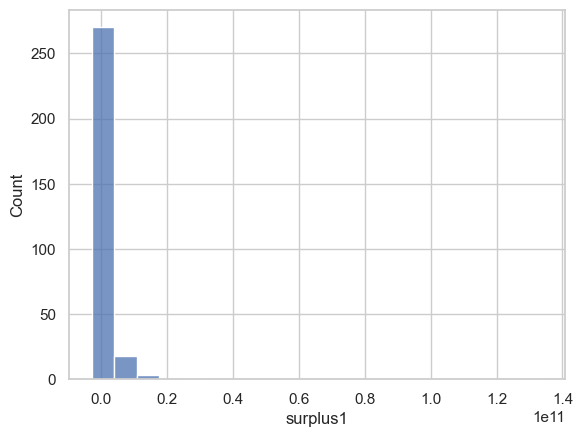

In [53]:
sns.set_theme(style='whitegrid')
sns.histplot(data=df,  x='surplus1',
             bins=20, ## 구간수
             cbar=True ## 컬러바 추가
            )


<Axes: xlabel='profit1', ylabel='Count'>

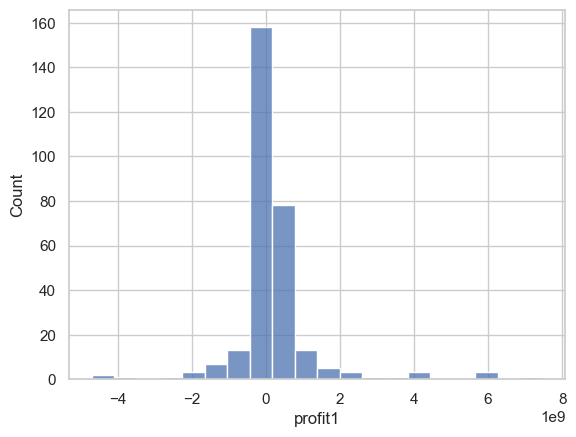

In [52]:
sns.set_theme(style='whitegrid')
sns.histplot(data=df,  x='profit1',
             bins=20, ## 구간수
             cbar=True ## 컬러바 추가
            )

<Axes: xlabel='employee1', ylabel='Count'>

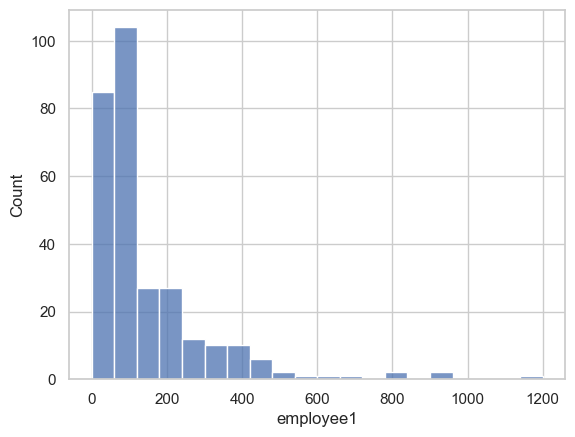

In [56]:
# employee1 

sns.set_theme(style='whitegrid')
sns.histplot(data=df,  x='employee1',
             bins=20, ## 구간수
             cbar=True ## 컬러바 추가
            )

<Axes: xlabel='employee2', ylabel='Count'>

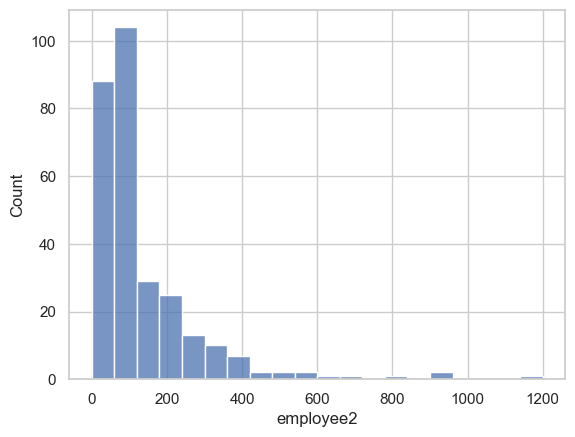

In [55]:
# employee1 

sns.set_theme(style='whitegrid')
sns.histplot(data=df,  x='employee2',
             bins=20, ## 구간수
             cbar=True ## 컬러바 추가
            )

<Axes: xlabel='inventoryAsset1', ylabel='Count'>

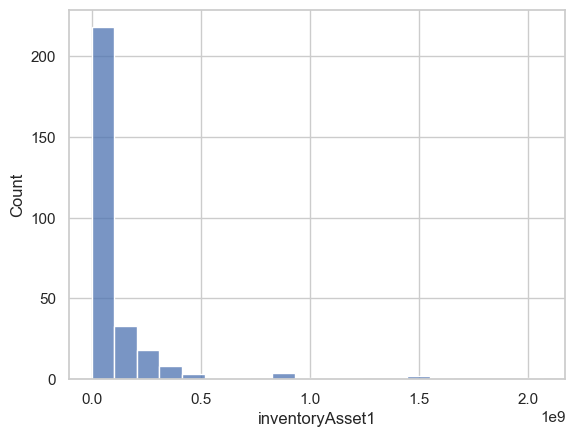

In [57]:
#inventoryAsset1

sns.set_theme(style='whitegrid')
sns.histplot(data=df,  x='inventoryAsset1',
             bins=20, ## 구간수
             cbar=True ## 컬러바 추가
            )

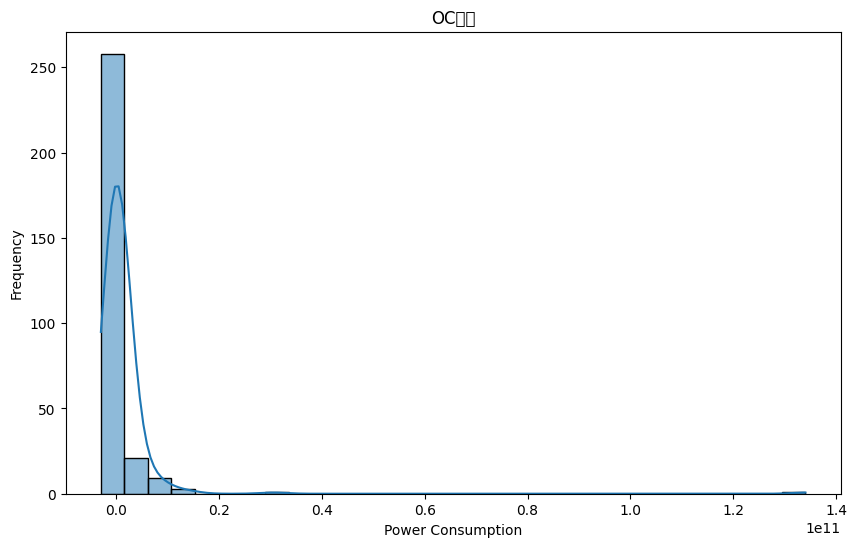

In [30]:
# histogram 생성
plt.figure(figsize=(10, 6))
sns.histplot(df['surplus1'], bins=30, kde=True)
plt.title('OC여부')
plt.xlabel('Power Consumption')
plt.ylabel('Frequency')
plt.show()

# ## 수직 히스토그램
# ax = sns.histplot(x=tip_df['total_bill'],
#                   color='r', ## 색상
#                   bins=10, ## bin 개수
#                   kde=True, ## 밀도 함수 곡선 추가
#                   element='step', ## 히스토그램 표시형식,
#                   stat='percent', ## y값 계산 방식 count
#                   cumulative=False, ## True인 경우 누적 분포 형태로 그림
#                  )

## 심화전처리

In [20]:
# 2017년 지역별 인구수 데이터
# https://kosis.kr/statHtml/statHtml.do?orgId=101&tblId=DT_1B040A3

pop = pd.read_csv(dirShare+"/data/행정구역_시군구_별__성별_인구수_20230718231833.csv", header=1, encoding="cp949")
pop.info()
pop.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   행정구역(시군구)별  18 non-null     object
 1   총인구수 (명)    18 non-null     int64 
 2   남자인구수 (명)   18 non-null     int64 
 3   여자인구수 (명)   18 non-null     int64 
dtypes: int64(3), object(1)
memory usage: 708.0+ bytes


,행정구역(시군구)별,총인구수 (명),남자인구수 (명),여자인구수 (명)
0,전국,51778544,25855919,25922625
1,서울특별시,9857426,4830206,5027220
2,부산광역시,3470653,1709508,1761145
3,대구광역시,2475231,1227814,1247417
4,인천광역시,2948542,1479597,1468945


In [146]:
# df와 pop(인구수) join
df_new = pd.merge(df, pop, how="inner", left_on="sido", right_on="행정구역(시군구)별")
df_clst = pd.merge(df_clst, pop, how="inner", left_on="sido", right_on="행정구역(시군구)별")
print(df_new.head())
print("-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-")
print(df_clst.head())

   inst_id  dif_date  OC  sido  sgg   openDate  bedCount        revenue1  \
0        1      3657   1  충청남도   73 2007-12-28   175.000  4217530010.000   
1       59      1385   1  충청남도   94 2014-03-18   258.000  8546126935.000   
2      101     13026   1  충청남도   37 1982-05-04   341.000 52626386641.000   
3      134     10804   1  충청남도   78 1988-06-03    64.000  4402779495.000   
4      150      1589   1  충청남도   94 2013-08-26   186.000  5237992090.000   

       salescost1            sga1  ...  instkind_dental_clinic  \
0           0.000  3961134739.000  ...                       0   
1           0.000  6737509250.000  ...                       0   
2 19326736791.000 32214235859.000  ...                       0   
3   719458530.000  4131517858.000  ...                       0   
4           0.000  5060655115.000  ...                       0   

   instkind_general_hospital  instkind_hospital  instkind_nursing_hospital  \
0                          0                  0                     

In [147]:
# 시도를 one-hot-encoding
df_new = pd.get_dummies(df_new, columns=["sido"], prefix=["sido"], prefix_sep="_", dtype=int)
df_clst = pd.get_dummies(df_clst, columns=["sido"], prefix=["sido"], prefix_sep="_", dtype=int)
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 84 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   inst_id                        301 non-null    int64         
 1   dif_date                       301 non-null    int64         
 2   OC                             301 non-null    int64         
 3   sgg                            301 non-null    int64         
 4   openDate                       301 non-null    datetime64[ns]
 5   bedCount                       296 non-null    float64       
 6   revenue1                       293 non-null    float64       
 7   salescost1                     293 non-null    float64       
 8   sga1                           293 non-null    float64       
 9   salary1                        293 non-null    float64       
 10  noi1                           293 non-null    float64       
 11  noe1               

In [148]:
# 병원 군집을 통해 결측치 예측을 하고자 함, surplus1 / 2, profit1 / 2, employee 1 / 2
df_clst.drop(columns="행정구역(시군구)별", axis=1, inplace=True)

df_clst.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 36 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   inst_id                        301 non-null    int64  
 1   dif_date                       301 non-null    int64  
 2   OC                             301 non-null    int64  
 3   bedCount                       296 non-null    float64
 4   profit1                        293 non-null    float64
 5   surplus1                       293 non-null    float64
 6   profit2                        293 non-null    float64
 7   surplus2                       293 non-null    float64
 8   employee1                      291 non-null    float64
 9   employee2                      288 non-null    float64
 10  instkind_clinic                301 non-null    int32  
 11  instkind_dental_clinic         301 non-null    int32  
 12  instkind_general_hospital      301 non-null    int

In [149]:
# NaN 값이 없는 컬럼만 남기고, 지역 데이터 없애기
df_kmeans = df_clst.dropna(axis=1, how="any")
df_kmeans = df_kmeans.iloc[:, :12]
df_kmeans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype
---  ------                         --------------  -----
 0   inst_id                        301 non-null    int64
 1   dif_date                       301 non-null    int64
 2   OC                             301 non-null    int64
 3   instkind_clinic                301 non-null    int32
 4   instkind_dental_clinic         301 non-null    int32
 5   instkind_general_hospital      301 non-null    int32
 6   instkind_hospital              301 non-null    int32
 7   instkind_nursing_hospital      301 non-null    int32
 8   instkind_traditional_clinic    301 non-null    int32
 9   instkind_traditional_hospital  301 non-null    int32
 10  총인구수 (명)                       301 non-null    int64
 11  남자인구수 (명)                      301 non-null    int64
dtypes: int32(7), int64(5)
memory usage: 20.1 KB


## kmeans를 통한 병원 세그먼트 군집

In [150]:
def visualize_silhouette(cluster_lists, X_features): 

    import matplotlib.cm as cm
    import math

    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)

    # plt.subplots()으로 리스트에 기재된 클러스터링 수만큼의 sub figures를 가지는 axs 생성 
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)

    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):

        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산. 
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(X_features)

        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)

        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])

        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현. 
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()

            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10

        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

In [151]:
scaler1 = MinMaxScaler()

scalerX1 = scaler1.fit(df_kmeans.iloc[:,3:])

X_mmsc1 = scaler1.transform(df_kmeans.iloc[:,3:])

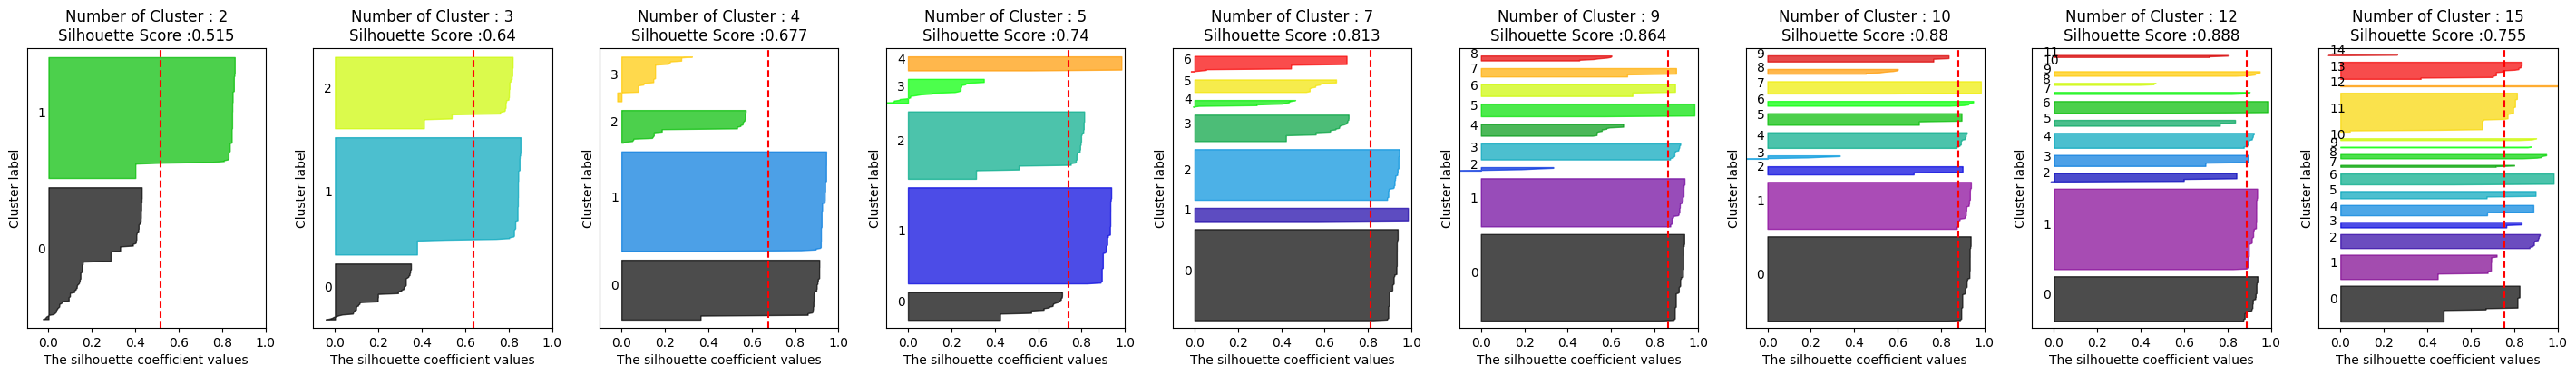

In [152]:
visualize_silhouette([2,3,4,5,7,9,10,12,15], X_mmsc1)
# 12개가 됐을 때 실루엣 계수가 0.888으로 최대

In [153]:
clst_kmeans = KMeans(n_clusters=12, random_state=0, max_iter=500)

model = clst_kmeans.fit(X_mmsc1)
clst_label = model.labels_

print(clst_label)

[ 1  1  4  0  1  1  1  8  1  0  1  9  9  1  1  1  1  1  1  1  1  9  0  4
  4  4  4  1  1  0  4  0  0  1  1  1  0  1  1  1  0  0  1  1  1  4  1  1
  1  1  1  0  1  0  1  1  0  1  6  2  2  2  8  6  6  3  3  5  3  3  6  6
  3  5  6  3  6  6  6  5  6  6  6  2  3  6 11  3  2  2  5  2  3  6  3  8
  5 11  6  6  3  2  2  2  3  6  6  4  0  4  4  0  1  0  1  1  0  4  1  1
  1  1  1  1  1  1  7  1  1  4  0  1  1  1  0  1  1  1  0  1  9  8  0  1
  1  1  4  0  0  0  1  1  1  0  1  1  0  1  1  1  1  4  0  1  2  2  2  3
  6 11  3  3 10  5  2  3  5  5  3  5  5  3 11  1  1  1  7  1  1  4  1  1
  1  0  1  0  9  1  0  1  4  1  0  1  1  0  1  0  1  1  1  1  1  1  4  4
  1  0  1  0  0  4  1  1  1  0  1  9  7  1  0  1  0  1  1  0  0  0  1  0
  0  0  1  0  0  0  4  0  1  0  1  0  4  1  1  0  0  0  1  0  1  0  1  1
  9  0  1  1  1  0  7  1  1  1  1  0  1  0  4  9  1  0  1  1  1  1  0  0
  0  1  0  0  0  0  4  4  0  0  1  0  1]


In [154]:
df_kmeans["NumberOfCluster"] = pd.Series(clst_label)
df_kmeans.tail()

,inst_id,dif_date,OC,instkind_clinic,instkind_dental_clinic,instkind_general_hospital,instkind_hospital,instkind_nursing_hospital,instkind_traditional_clinic,instkind_traditional_hospital,총인구수 (명),남자인구수 (명),NumberOfCluster
296,369,5822,1,0,0,0,1,0,0,0,1550142,780635,0
297,385,1024,1,0,0,0,1,0,0,0,1550142,780635,0
298,289,1204,1,0,0,0,0,1,0,0,1463770,725295,1
299,290,3393,1,0,0,0,1,0,0,0,1463770,725295,0
300,355,4695,1,0,0,0,0,1,0,0,280100,139734,1


In [ ]:
# df_kmeans.head()

In [155]:
df_kmeans.groupby(by="NumberOfCluster", axis=0)["inst_id"].count()

NumberOfCluster
0      70
1     125
2      14
3      18
4      24
5      10
6      19
7       4
8       4
9       8
10      1
11      4
Name: inst_id, dtype: int64

In [156]:
# 재무 정보가 포함돼 있는 데이터 프레임에 클러스터링 넘버 삽입
df_join_clst = pd.merge(df_clst, df_kmeans[["inst_id", "NumberOfCluster"]], how="left", left_on="inst_id", right_on="inst_id")
df_join_clst.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 37 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   inst_id                        301 non-null    int64  
 1   dif_date                       301 non-null    int64  
 2   OC                             301 non-null    int64  
 3   bedCount                       296 non-null    float64
 4   profit1                        293 non-null    float64
 5   surplus1                       293 non-null    float64
 6   profit2                        293 non-null    float64
 7   surplus2                       293 non-null    float64
 8   employee1                      291 non-null    float64
 9   employee2                      288 non-null    float64
 10  instkind_clinic                301 non-null    int32  
 11  instkind_dental_clinic         301 non-null    int32  
 12  instkind_general_hospital      301 non-null    int

In [157]:
df_join_clst[df_join_clst.isna().any(axis=1)]

,inst_id,dif_date,OC,bedCount,profit1,surplus1,profit2,surplus2,employee1,employee2,...,sido_부산광역시,sido_서울특별시,sido_세종특별자치시,sido_울산광역시,sido_인천광역시,sido_전라남도,sido_전라북도,sido_충청남도,sido_충청북도,NumberOfCluster
19,362,11343,1,50.000,NaN,NaN,NaN,NaN,93.000,89.000,...,0,0,0,0,0,0,0,1,0,1
22,423,1293,0,NaN,-1622521056.000,0.000,0.000,0.000,79.000,79.000,...,0,0,0,0,0,0,0,1,0,0
23,3,7580,1,410.000,NaN,NaN,NaN,NaN,801.000,813.000,...,0,0,0,0,0,0,0,0,0,4
48,298,346,1,160.000,-682998400.000,0.000,0.000,0.000,NaN,103.000,...,0,0,0,0,0,0,0,0,0,1
64,58,1790,0,132.000,118187869.000,0.000,73537185.000,0.000,51.000,NaN,...,0,0,0,0,0,0,0,0,0,6
71,87,1754,1,327.000,NaN,NaN,NaN,NaN,200.000,203.000,...,0,0,0,0,0,0,0,0,0,6
83,281,1845,0,NaN,-261130839.000,0.000,-423739612.000,0.000,15.000,15.000,...,0,0,0,0,0,0,0,0,0,2
89,353,5052,1,255.000,NaN,NaN,NaN,NaN,255.000,244.000,...,0,0,0,0,0,0,0,0,0,2
106,427,4018,0,180.000,-1850554348.000,0.000,-2729675155.000,0.000,100.000,NaN,...,0,0,0,0,0,0,0,0,0,6
110,55,8943,1,232.000,NaN,NaN,NaN,NaN,323.000,323.000,...,0,0,0,0,1,0,0,0,0,4


In [158]:
df_join_clst.groupby(by="NumberOfCluster", axis=1).iloc[:,3:9]

,employee2,instkind_clinic,instkind_dental_clinic,instkind_general_hospital,instkind_hospital,instkind_nursing_hospital,instkind_traditional_clinic,instkind_traditional_hospital,총인구수 (명),남자인구수 (명),...,sido_부산광역시,sido_서울특별시,sido_세종특별자치시,sido_울산광역시,sido_인천광역시,sido_전라남도,sido_전라북도,sido_충청남도,sido_충청북도,NumberOfCluster
182,15.000,0,0,0,0,0,0,1,9857426,4830206,...,0,1,0,0,0,0,0,0,0,11


## SVD를 위한 작업

데이터의 양은 독립변수 수의 3배 이상은 돼야 함.
독립변수로 작용하는 컬럼 수가 57개이므로 다중 공선성과 과적합, 차원의 저주의 영향이 예상되므로
차원 축소 필요

In [ ]:
# 결측치가 있는 컬럼 추출
df_null = df_clst[df_clst.isna().any(axis=1)]
df_null.head(10)

In [ ]:
# 병원 정보에 NULL이 존재하는 부분을 다른 값으로 대체할 수 없음
# 병원의 매출, 비용, 이익, 직원 수와 같은 값을 다른 병원의 평균이나 중앙값으로 대체하면 안 됨
# 회귀대체법을 하기에는 종속 변수로 둘 만한 속성값이 존재 X
# null이 포함된 데이터가 전체 데이터의 10% 미만이므로 

df.dropna(axis=0, how="any", inplace=True)
df.shape[0]

In [ ]:
# 데이터 값이 0으로만 돼 있는 컬럼 삭제
df.drop(columns=["receivableL1", "receivableL2"], axis=1, inplace=True)
# 시군구 코드 삭제
df.drop(columns="sgg", axis=1, inplace=True)
# 병원 id는 분석에 있어서 의미가 없는 데이터이므로 삭제
df.drop(columns="inst_id",inplace=True)
# 데이터 프레임에서 drop 됐는지 확인
# df.columns

In [ ]:
df_drop_obj = copy.deepcopy(df)  # 깊은 복사
df_dr_obj_cols = df_drop_obj.columns.to_list()
# df_dr_obj_cols

🫡시도코드와 시군구 코드를 학습시킬 수도 있습니다.  
One-Hot Encoding을 이용하면 되죠.  
하지만 재무 정보와 관련된 현 데이터에서는 의미가 없을 것 같습니다.  
그 이유는 지역의 이름 자체가, 변수로서 큰 영향력을 가지지는 않을 것 같거든요!!  
지역이 변수로 영향을 가지려면, 그 지역의 면적, 인구밀도, 평균 소득💸 등으로 대체해야 할 것 같습니다.  
일단 지금은 재무 정보에 대한 것으로만 예측을 해보죠!  

In [ ]:
df_drop_obj2 = copy.deepcopy(df_drop_obj)

# 컬럼 데이터 타입이 'object'인 컬럼 삭제
for i in range(len(df_dr_obj_cols)) : 
    if df_drop_obj.iloc[:,i].dtype == "object" : 
        df_drop_obj2.drop(columns=df_dr_obj_cols[i], inplace=True)

df_drop_obj = df_drop_obj2
# df_drop_obj.info()

In [ ]:
# 개업 날짜를 drop한 새로운 데이터프레임 생성
df_hos = df_drop_obj.drop(columns="openDate")

In [ ]:
# 독립변수 컬럼 샤피로 윌크 검정으로 정규성 확인
# H0 : 변수는 정규성을 따른다.
# H1 : 변수는 정규성을 따르지 않는다.

cnt = 0

for i in range(df_hos.shape[1]) : 
    cnt += 1
    shapiro_tt = stats.shapiro(df_hos.iloc[:,i])
    print(cnt)
    if shapiro_tt[1] > 0.05 : 
        print("컬럼명 ",df_hos.columns[i],"는(은) 귀무가설을 채택, 정규성을 따른다고 가정할 수 있습니다.")
    else : 
        print("컬럼명 ",df_hos.columns[i],"는(은) 귀무가설을 기각, 정규성을 따른다고 가정할 수 없습니다.")
    print("-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-")

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))    # 그래프 사이즈 지정
stats.probplot(df_hos.iloc[:,7], dist=stats.norm, plot=plt) #Sample은 어느 정도 어긋났는지 비교할 분포,
                                                  #dist는 기준이 되는 분포, 정규 분포가 아니어도 된다.
                                                  #plot은 주로 matplotlib.plt 객체 사용
plt.show()

In [ ]:
scaler = MinMaxScaler()

scalerX = scaler.fit(df_hos.iloc[:,1:])

X_mmsc = scaler.transform(df_hos.iloc[:,1:])

# X_mmsc

In [ ]:
import numpy as np
from sklearn.decomposition import TruncatedSVD

# 차원 축소를 위한 SVD 수행
svd = TruncatedSVD(n_components=6)
make_svd = svd.fit(X_mmsc)
X_train_red = svd.transform(X_mmsc)

## statsmodels를 사용한 vif 계산

In [ ]:
# 병원 개/폐업 정보의 다중 회귀 분석과 검정 통계량 확인
Models1 = sm.ols("OC ~ " + "+".join(df_hos.columns[1:]), data=df_hos)
result1 = Models1.fit()
print(result1.summary())

In [ ]:
# 독립변수 X와 종속변수 y로 분리
X = df_hos.iloc[:,1:]
y = df_hos.iloc[:,0]

In [ ]:
# 독립변수들간 다중 공선성 확인, vif 지수 10 이상이면 변수 제거 고려
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values,i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif = vif.sort_values("VIF Factor").reset_index(drop=True)
vif

In [ ]:
# vif 지수가 10미만인 컬럼명
vif[vif["VIF Factor"]<10.0]["features"]

In [ ]:
feat_vif = vif[vif["VIF Factor"]<10.0]["features"]

fvList = [feat_vif[f] for f in range(len(feat_vif))]

In [ ]:
fvList.insert(0, "OC")

In [ ]:
df_drop_vif = df_hos[fvList]
# df_drop_vif.head()

In [ ]:
Models2 = sm.ols("OC ~ " + "+".join(df_drop_vif.columns[1:]), data=df_drop_vif)
result2 = Models2.fit()
print(result2.summary())

In [ ]:
"""
vif 지수가 10 이상이라고 무조건 제거하면 안 됨!
"""

# 모델학습

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=626, stratify=y)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

In [ ]:
model_xgb = XGBClassifier()
xgb_model = model_xgb.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)
y_pred_prob = xgb_model.predict_proba(X_test)[:1]

In [ ]:
X2 = df_drop_vif.iloc[:,1:]
y2 = df_drop_vif.iloc[:,0]

X_train2, X_test2, y_train2, y_test2= train_test_split(X2, y2, test_size=0.2, random_state=626, stratify=y2)
print(X_train2.shape)
print(X_test2.shape)
print(y_train2.shape)
print(y_test2.shape)

model_xgb2 = XGBClassifier()
xgb_model2 = model_xgb2.fit(X_train2, y_train2)

y_pred2 = xgb_model2.predict(X_test2)
y_pred_prob2 = xgb_model2.predict_proba(X_test2)[:1]

print("정확도 : ",accuracy_score(y_test2, y_pred2))
print("f1 socre : ",f1_score(y_test2, y_pred2))

In [ ]:
y_train_red = df_hos.iloc[:,0].to_numpy()

print(y_train_red)
print(y_train_red.shape)

In [ ]:
X_train3, X_test3, y_train3, y_test3= train_test_split(X_train_red, y_train_red, test_size=0.2, random_state=626, stratify=y_train_red)
print(X_train3.shape)
print(X_test3.shape)
print(y_train3.shape)
print(y_test3.shape)

model_xgb_svd = XGBClassifier()
xgb_model_svd = model_xgb_svd.fit(X_train3, y_train3)

y_pred3 = xgb_model_svd.predict(X_test3)

print("정확도 : ",accuracy_score(y_test3, y_pred3))
print("f1 socre : ",f1_score(y_test3, y_pred3))

# 병원 정보 api 불러오기

In [ ]:
"""
https://apis.data.go.kr/B551182/hospInfoServicev2/getHospBasisList?serviceKey=repbMvjCXw96iTs6wjKM3Htm1H480VcdawruKmikMmOYZF8aVD%2FrJDkfGoyLeTuS5Y1KEOzUrwwPIu87UQ9LbQ%3D%3D&pageNo=1&numOfRows=10&sidoCd=110000&sgguCd=110019&emdongNm=%EC%8B%A0%EB%82%B4%EB%8F%99&yadmNm=%EC%84%9C%EC%9A%B8%EC%9D%98%EB%A3%8C%EC%9B%90&zipCd=2010&clCd=11&dgsbjtCd=01&xPos=127.09854004628151&yPos=37.6132113197367&radius=3000
"""

In [ ]:
serviceKey = "repbMvjCXw96iTs6wjKM3Htm1H480VcdawruKmikMmOYZF8aVD/rJDkfGoyLeTuS5Y1KEOzUrwwPIu87UQ9LbQ=="
serviceKeyDecoded = parse.unquote(serviceKey, 'UTF-8')

url = "http://apis.data.go.kr/B551182/hospInfoServicev2/getHospBasisList"
returnType="xml"
Pindex = 1
Psize = 1000


queryParams = '?' + parse.urlencode({ parse.quote_plus("serviceKey") : serviceKeyDecoded,
                                parse.quote_plus("numOfRows") : '10000',
                                parse.quote_plus("pageNo") : '2'
                                    })

res = requests.get(url + queryParams)

In [ ]:
soup = BeautifulSoup(res.text, 'lxml-xml')
items = soup.find_all("item")

In [ ]:
pprint.pprint(items)

In [ ]:
len(items)

In [ ]:
def parse():
    try:
        ADDR = item.find("addr").get_text()
        CLCD = item.find("clCd").get_text()
        CLCDNM = item.find("clCdNm").get_text()
        EMDONGNM = item.find("emdongNm").get_text()
        ESTBDB = item.find("estbDd").get_text()
        POSTNO = item.find("postNo").get_text()
        SGGUCD = item.find("sgguCd").get_text()
        SGGUCDNM = item.find("sgguCdNm").get_text()
        SIDOCD = item.find("sidoCd").get_text()
        SIDOCDNM = item.find("sidoCdNm").get_text()
        XPOS = item.find("XPos").get_text()
        YPOS = item.find("YPos").get_text()
        YADMNM = item.find("yadmNm").get_text()
        YKIHO = item.find("ykiho").get_text()
        return {
            "주소":ADDR,
            "종별코드":CLCD,
            "종별코드명":CLCDNM,
            "읍면동":EMDONGNM,
            "개설일자":ESTBDB,
            "Post No.":POSTNO,
            "시군구코드":SGGUCD,
            "시군구코드명":SGGUCDNM,
            "시도코드":SIDOCD,
            "시도코드명":SIDOCDNM,
            "x좌표":XPOS,
            'y좌표':YPOS,
            "요양기관명":YADMNM,
            "암호화요양기호":YKIHO
        }
    except AttributeError as e:
        return {
            "주소":None,
            "종별코드":None,
            "종별코드명":None,
            "읍면동":None,
            "개설일자":None,
            "Post No.":None,
            "시군구코드":None,
            "시군구코드명":None,
            "시도코드":None,
            "시도코드명":None,
            "x좌표":None,
            'y좌표':None,
            "요양기관명":None,
            "암호화요양기호":None
        }

In [ ]:
row = list()

for item in items : 
    row.append(parse())

In [ ]:
df_api = pd.DataFrame(row)
df_api.head()

In [ ]:
df_api.shape[0] - df_api.count()

In [ ]:
df_api.dropna(axis=0, how="any", inplace=True)
df_api.shape

In [ ]:
df_api.to_csv(dirShare+"/data/병원정보api_day2.csv",sep=',', encoding="utf-8")

In [ ]:
df_day1  = pd.read_csv(dirShare+"/data/병원정보api.csv")
df_day1.info()
df_day1.head(10)

In [ ]:
df_day2  = pd.read_csv(dirShare+"/data/병원정보api_day2.csv")
df_day2.info()
df_day2.head(10)

In [ ]:
df_day1.sort_values(by='종별코드', axis=0, ascending=True)

In [ ]:
df_day2.sort_values(by='종별코드', axis=0, ascending=True)